In [24]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, ElasticNet, BayesianRidge
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, RepeatedKFold, cross_val_score, train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import sklearn.metrics as sm
from sklearn.metrics import PredictionErrorDisplay
from sklearn.tree import export_graphviz

from IPython.display import Image
import pydotplus
import os
import six
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [25]:
def display_prediction_error(y_test, y_pred, feature="Redshift"):
    fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
    PredictionErrorDisplay.from_predictions(
        y_test,
        y_pred=y_pred,
        kind="actual_vs_predicted",
        ax=axs[0]
    )
    axs[0].set_title(f"Actual vs. Predicted {feature}")
    PredictionErrorDisplay.from_predictions(
        y_test,
        y_pred=y_pred,
        kind="residual_vs_predicted",
        ax=axs[1]
    )
    axs[1].set_title(f"Residuals vs. Predicted {feature}")
    plt.tight_layout()
    plt.show()

def calculate_RSME(model, X_train, y_train, cv=3):
    scores = cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=cv, n_jobs=-1)

    return np.sqrt(np.mean(np.absolute(scores)))


<h1>Feature Engineering and Data Cleaning

In [26]:
# converts name to GW###### format for visualization purposes
def simplify_name(name):
    if str.startswith(name, "GW"):
        return "GW" + name[2:8]
    return "GW" + name[0:6]

# extracts version number from name
def extract_version(name):
    return name[-1:]

# extracts confidence from catalog.shortName
def extract_group(shortname):
    if "2.1" in shortname:
        return shortname[9:]
    return shortname[7:]

# gets confidence number of group
def extract_confidence(group):
    if group == "confident":
        return 3
    if group == "marginal":
        return 2
    if group == "auxiliary":
        return 1
    return 0

O3_all = pd.read_csv("../Data/GWTC-3.csv")
O3_all["simple_name"] = np.array([simplify_name(name) for name in O3_all["name"]])
O3_all["group"] = np.array([3 for _ in range(O3_all["name"].size)])
O3_all["catalog"] = np.array([extract_group(shortname) for shortname in O3_all["catalog.shortName"]])
O3_all["confidence"] = np.array([extract_confidence(group) for group in O3_all["catalog"]])
O3_all["group_name"] = np.array(["O" + str(group) for group in O3_all["group"]])
O3_all = O3_all[["name", "simple_name", "catalog", "confidence", "version", "group_name", "group", "GPS", "far", "network_matched_filter_snr", "mass_1_source", "mass_2_source", "chirp_mass_source", "redshift", "luminosity_distance"]]
O3_all = O3_all.rename(columns={"network_matched_filter_snr": "snr", "GPS": "gps", "mass_1_source": "mass1", "mass_2_source": "mass2", "chirp_mass_source": "chirp_mass", "combined_far": "far"})

O2_confident = pd.read_csv("../Data/GWTC-2_1-confident.csv")
O2_confident["simple_name"] = np.array([simplify_name(name) for name in O2_confident["name"]])
O2_confident["group"] = np.array([2 for _ in range(O2_confident["name"].size)])
O2_confident["group_name"] = np.array(["O" + str(group) for group in O2_confident["group"]])
O2_confident["catalog"] = np.array([extract_group(shortname) for shortname in O2_confident["catalog.shortName"]])
O2_confident["confidence"] = np.array([extract_confidence(group) for group in O2_confident["catalog"]])
O2_confident = O2_confident[["name", "simple_name", "catalog", "confidence", "version", "group_name", "group", "GPS", "far", "network_matched_filter_snr", "mass_1_source", "mass_2_source", "chirp_mass_source", "redshift", "luminosity_distance"]]
O2_confident = O2_confident.rename(columns={"network_matched_filter_snr": "snr", "GPS": "gps", "mass_1_source": "mass1", "mass_2_source": "mass2", "chirp_mass_source": "chirp_mass", "combined_far": "far"})

O2_marginal = pd.read_csv("../Data/GWTC-2_1-marginal.csv")
O2_marginal["simple_name"] = np.array([simplify_name(name) for name in O2_marginal["name"]])
O2_marginal["group"] = np.array([2 for _ in range(O2_marginal["name"].size)])
O2_marginal["group_name"] = np.array(["O" + str(group) for group in O2_marginal["group"]])
O2_marginal["catalog"] = np.array([extract_group(shortname) for shortname in O2_marginal["catalog.shortName"]])
O2_marginal["confidence"] = np.array([extract_confidence(group) for group in O2_marginal["catalog"]])
O2_marginal = O2_marginal[["name", "simple_name", "catalog", "confidence", "version", "group_name", "group", "GPS", "far", "network_matched_filter_snr", "mass_1_source", "mass_2_source", "chirp_mass_source", "redshift", "luminosity_distance"]]
O2_marginal = O2_marginal.rename(columns={"network_matched_filter_snr": "snr", "GPS": "gps", "mass_1_source": "mass1", "mass_2_source": "mass2", "chirp_mass_source": "chirp_mass", "combined_far": "far"})

O2_auxiliary = pd.read_csv("../Data/GWTC-2_1-auxiliary.csv")
O2_auxiliary["simple_name"] = np.array([simplify_name(name) for name in O2_auxiliary["name"]])
O2_auxiliary["group"] = np.array([2 for _ in range(O2_auxiliary["name"].size)])
O2_auxiliary["group_name"] = np.array(["O" + str(group) for group in O2_auxiliary["group"]])
O2_auxiliary["catalog"] = np.array([extract_group(shortname) for shortname in O2_auxiliary["catalog.shortName"]])
O2_auxiliary["confidence"] = np.array([extract_confidence(group) for group in O2_auxiliary["catalog"]])
O2_auxiliary = O2_auxiliary[["name", "simple_name", "catalog", "confidence", "version", "group_name", "group", "GPS", "far", "network_matched_filter_snr", "mass_1_source", "mass_2_source", "chirp_mass_source", "redshift", "luminosity_distance"]]
O2_auxiliary = O2_auxiliary.rename(columns={"network_matched_filter_snr": "snr", "GPS": "gps", "mass_1_source": "mass1", "mass_2_source": "mass2", "chirp_mass_source": "chirp_mass", "combined_far": "far"})

O1_all = pd.read_csv("../Data/GWTC-1.csv")
O1_all["simple_name"] = np.array([simplify_name(name) for name in O1_all["name"]])
O1_all["group"] = np.array([1 for _ in range(O1_all["name"].size)])
O1_all["catalog"] = np.array([extract_group(shortname) for shortname in O1_all["catalog.shortName"]])
O1_all["confidence"] = np.array([extract_confidence(group) for group in O1_all["catalog"]])
O1_all["group_name"] = np.array(["O" + str(group) for group in O1_all["group"]])
O1_all = O1_all[["name", "simple_name", "catalog", "confidence", "version", "group_name", "group", "GPS", "far", "network_matched_filter_snr", "mass_1_source", "mass_2_source", "chirp_mass_source", "redshift", "luminosity_distance"]]
O1_all = O1_all.rename(columns={"network_matched_filter_snr": "snr", "GPS": "gps", "mass_1_source": "mass1", "mass_2_source": "mass2", "chirp_mass_source": "chirp_mass", "combined_far": "far"})

observations = O3_all
observations = observations.append(O2_confident)
observations = observations.append(O2_marginal)
observations = observations.append(O2_auxiliary)
observations = observations.append(O1_all)

observations["total_mass"] = observations["mass1"] + observations["mass2"]
observations["mass_ratio"] = observations["mass2"] / observations["mass1"]

observations["is_O1"] = observations["group"] == 1
observations["is_O2"] = observations["group"] == 2
observations["is_O3"] = observations["group"] == 3

confident = observations[observations['confidence'] == 3]

C:\Users\lucas\AppData\Local\Temp\ipykernel_25968\2511988135.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  observations = observations.append(O2_confident)
C:\Users\lucas\AppData\Local\Temp\ipykernel_25968\2511988135.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  observations = observations.append(O2_marginal)
C:\Users\lucas\AppData\Local\Temp\ipykernel_25968\2511988135.py:75: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  observations = observations.append(O2_auxiliary)
C:\Users\lucas\AppData\Local\Temp\ipykernel_25968\2511988135.py:76: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  observations = observations.append(O1_all)

<h1>Pre-processing

In [27]:
train, test, y_train, y_test = train_test_split(confident, confident['redshift'], test_size=0.20, random_state=13)

In [51]:
model1 = RandomForestRegressor(random_state=13)

model1.fit(train[["snr", "far", "chirp_mass", "total_mass", "mass_ratio"]], y_train)

y_pred = model1.predict(test[["snr", "far", "chirp_mass", "total_mass", "mass_ratio"]])

print("Mean absolute error =", round(sm.mean_absolute_error(y_test, y_pred), 4)) 
print("Mean squared error =", round(sm.mean_squared_error(y_test, y_pred), 4)) 
print("Median absolute error =", round(sm.median_absolute_error(y_test, y_pred), 4)) 
print("Explain variance score =", round(sm.explained_variance_score(y_test, y_pred), 2)) 
print("R2 score =", round(sm.r2_score(y_test, y_pred), 3))

Mean absolute error = 0.0767
Mean squared error = 0.0079
Median absolute error = 0.0649
Explain variance score = 0.78
R2 score = 0.757


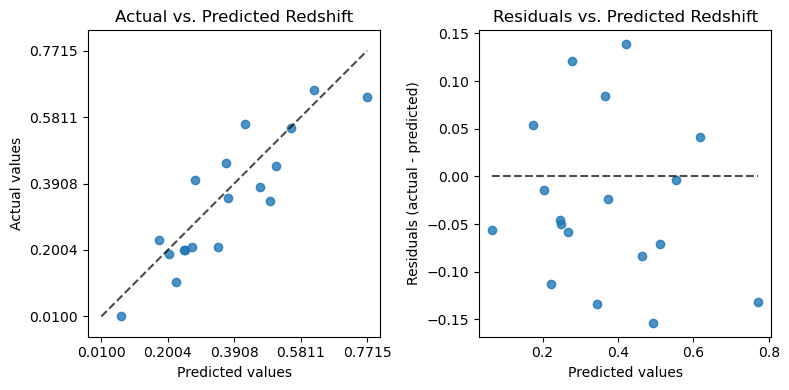

In [29]:
display_prediction_error(y_test=y_test, y_pred=y_pred)

In [48]:
feature_names = ["snr", "far", "chirp_mass", "total_mass", "mass_ratio"]

importances = model1.feature_importances_

std = np.std([tree.feature_importances_ for tree in model1.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(len(feature_names)):
    print(f"{f + 1}. {feature_names[indices[f]]} ({importances[indices[f]]:0.2f})")

Feature ranking:
1. mass2 (0.40)
2. snr (0.29)
3. mass1 (0.15)
4. far (0.12)
5. mass_ratio (0.04)


In [31]:
feature_names = ["snr", "far", "chirp_mass", "total_mass"]

control_RSME = calculate_RSME(RandomForestRegressor(random_state=13), train[feature_names], y_train, RepeatedKFold(n_splits=3, n_repeats=100, random_state=13))
print("Base")
print(f"RSME {control_RSME:0.4f}")
print()

for feature in feature_names:
    without_feature = feature_names.copy()
    without_feature.remove(feature)
    no_feature_RSME = calculate_RSME(RandomForestRegressor(random_state=13), train[without_feature], y_train, RepeatedKFold(n_splits=3, n_repeats=100, random_state=13))
    print(f"No {feature}")
    print(f"RSME {no_feature_RSME:0.4f}")
    print(f"Diffrence {no_feature_RSME - control_RSME:0.4f}")
    print()

Base
RSME 0.1192

No snr
RSME 0.1367
Diffrence 0.0175

No far
RSME 0.1169
Diffrence -0.0023

No chirp_mass
RSME 0.1198
Diffrence 0.0006

No total_mass
RSME 0.1207
Diffrence 0.0015



In [32]:
feature_names = ["snr", "chirp_mass", "total_mass"]

control_RSME = calculate_RSME(RandomForestRegressor(random_state=13), train[feature_names], y_train, RepeatedKFold(n_splits=3, n_repeats=100, random_state=13))
print("Base")
print(f"RSME {control_RSME:0.4f}")
print()

for feature in feature_names:
    without_feature = feature_names.copy()
    without_feature.remove(feature)
    no_feature_RSME = calculate_RSME(RandomForestRegressor(random_state=13), train[without_feature], y_train, RepeatedKFold(n_splits=3, n_repeats=100, random_state=13))
    print(f"No {feature}")
    print(f"RSME {no_feature_RSME:0.4f}")
    print(f"Diffrence {no_feature_RSME - control_RSME:0.4f}")
    print()

    only_feature_RSME = calculate_RSME(RandomForestRegressor(random_state=13), train[[feature]], y_train, RepeatedKFold(n_splits=3, n_repeats=100, random_state=13))
    print(f"Only {feature}")
    print(f"RSME {only_feature_RSME:0.4f}")
    print(f"Diffrence {only_feature_RSME - control_RSME:0.4f}")
    print()

Base
RSME 0.1169

No snr
RSME 0.2009
Diffrence 0.0840

Only snr
RSME 0.2272
Diffrence 0.1103

No chirp_mass
RSME 0.1174
Diffrence 0.0004

Only chirp_mass
RSME 0.2089
Diffrence 0.0919

No total_mass
RSME 0.1186
Diffrence 0.0016

Only total_mass
RSME 0.2118
Diffrence 0.0949



In [33]:
model2 = RandomForestRegressor(random_state=13)

model2.fit(train[["snr", "total_mass"]], y_train)

y_pred = model2.predict(test[["snr", "total_mass"]])

print("Mean absolute error =", round(sm.mean_absolute_error(y_test, y_pred), 4))
print("Mean squared error =", round(sm.mean_squared_error(y_test, y_pred), 4))
print("Median absolute error =", round(sm.median_absolute_error(y_test, y_pred), 4))
print("Explain variance score =", round(sm.explained_variance_score(y_test, y_pred), 2))
print("R2 score =", round(sm.r2_score(y_test, y_pred), 3))

Mean absolute error = 0.0782
Mean squared error = 0.008
Median absolute error = 0.0755
Explain variance score = 0.78
R2 score = 0.751


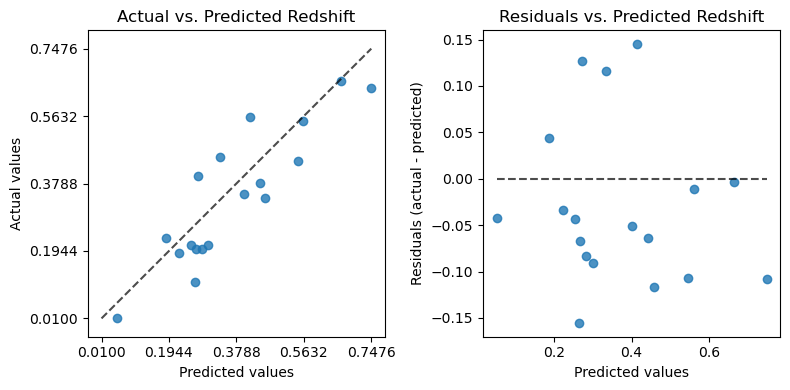

In [34]:
display_prediction_error(y_test=y_test, y_pred=y_pred)

<h1>Hyper-parameter Tuning

In [45]:
random_grid = {
    'max_features':[1, 2],
    'max_depth': np.arange(2,9,1),
    'n_estimators':np.arange(50,200,15),
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'criterion': ['squared_error', 'absolute_error', 'friedman_mse'],
    'bootstrap': [True],
    'max_samples': [0.3, 0.5, 0.8]
}

rf = RandomForestRegressor(random_state=13)

random_search = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=500, cv=3, verbose=2, n_jobs=-1)

random_search.fit(train[["snr", "total_mass"]], y_train)

random_search.best_params_

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


{'n_estimators': 125,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_samples': 0.8,
 'max_features': 2,
 'max_depth': 5,
 'criterion': 'squared_error',
 'bootstrap': True}

In [46]:
model3 = random_search.best_estimator_

model3.fit(train[["snr", "total_mass"]], y_train)

y_pred = model3.predict(test[["snr", "total_mass"]])

print("Mean absolute error =", round(sm.mean_absolute_error(y_test, y_pred), 4)) 
print("Mean squared error =", round(sm.mean_squared_error(y_test, y_pred), 4)) 
print("Median absolute error =", round(sm.median_absolute_error(y_test, y_pred), 4)) 
print("Explain variance score =", round(sm.explained_variance_score(y_test, y_pred), 2)) 
print("R2 score =", round(sm.r2_score(y_test, y_pred), 3))

Mean absolute error = 0.0799
Mean squared error = 0.008
Median absolute error = 0.0777
Explain variance score = 0.78
R2 score = 0.752


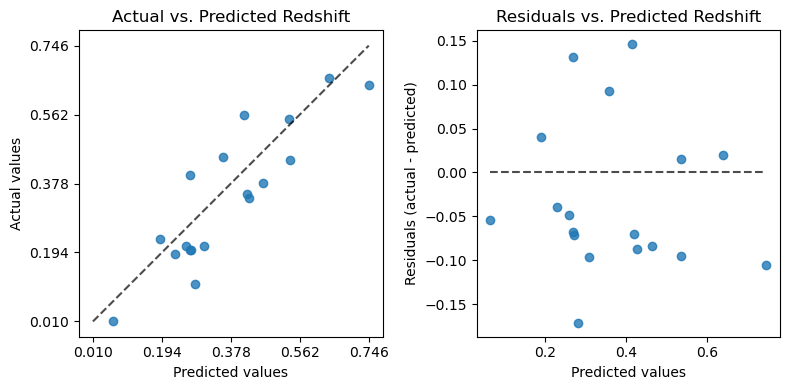

In [47]:
display_prediction_error(y_test=y_test, y_pred=y_pred)